Cosetes

In [66]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

In [ ]:
from sklearn.preprocessing import MinMaxScaler


file_path = '../../accions.csv'
file_path2 = '../../tramits.csv'
# Load the CSV file
df = pd.read_csv(file_path)

# Sample 10000 random rows from the dataframe
#df = df.sample(n=40000, random_state=42)
#df = df[df['Usuari'].notnull()]
#df = df[df['Accio'].notnull()]
df_tramits = pd.read_csv(file_path2)

# Merge the two dataframes on 'Tramit' and 'id'
df = pd.merge(df, df_tramits, left_on='Tramit', right_on='Id', how='inner')

df['Data'] = pd.to_datetime(df['Data'])

df['Año'] = df['Data'].dt.year
df['Mes'] = df['Data'].dt.month
df['Hora'] = df['Data'].dt.hour
df['Día de la semana'] = df['Data'].dt.weekday  # 0 = Lunes, 6 = Domingo

# Estandarizar las nuevas columnas
scaler = MinMaxScaler()
df[['Año', 'Mes', 'Hora', 'Día de la semana']] = scaler.fit_transform(df[['Año', 'Mes', 'Hora', 'Día de la semana']])

df['Representat'] = df['Representat'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['Usuari'] = df['Usuari'].apply(lambda x: 1 if pd.notnull(x) else 0)

df = df.drop(columns=['Id', 'Sessio','Tramit','Data'])
# Normalize the titles by converting them to lowercase

In [68]:
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
sentences = df['Titol'].apply(lambda x: x.split())
model = Word2Vec(sentences, vector_size=30, window=5, min_count=1, workers=4)

def get_sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

df_embeddings = pd.DataFrame(df['Titol'].apply(get_sentence_vector).to_list())

scaler = MinMaxScaler()

# Estandarizar las representaciones vectoriales
df_embeddings_standardized = scaler.fit_transform(df_embeddings)

# Convertir el resultado de nuevo a un DataFrame si lo necesitas
df_embeddings = pd.DataFrame(df_embeddings_standardized)
# Imprimir las primeras filas del DataFrame con las representaciones vectoriales
df_embeddings.columns = [str(i) for i in range(df_embeddings.shape[1])]
print(df_embeddings.head())

          0         1         2         3         4         5         6  \
0  0.386247  0.720725  0.366649  0.565751  0.544938  0.640051  0.484276   
1  0.838111  0.625001  0.259609  0.150601  0.902509  0.314028  0.185816   
2  0.473098  0.471506  0.588254  0.631003  0.302022  0.143247  0.367722   
3  0.575592  0.720442  0.923098  0.493655  0.491704  0.837823  0.393128   
4  0.662895  0.532894  0.120608  0.640360  0.651439  0.390727  0.605060   

          7         8         9  ...        20        21        22        23  \
0  0.576356  0.383677  0.485504  ...  0.178075  0.580223  0.720879  0.356706   
1  0.484744  0.753290  0.474255  ...  0.302293  0.882199  0.629980  0.449348   
2  0.748890  0.417186  0.483257  ...  0.185055  0.845642  0.373963  0.439650   
3  0.695916  0.736676  0.278291  ...  0.620602  0.672025  0.746974  0.347536   
4  0.881668  0.999809  0.743143  ...  0.422753  0.536487  0.131045  0.687301   

         24        25        26        27        28        29  
0  0

In [69]:
dfnou = df.drop(columns=['Titol'])
dfnou = pd.concat([dfnou, df_embeddings], axis=1)
dfnou['Vigent'] = dfnou['Vigent'].apply(lambda x: 1 if x else 0)

#df['Accio'] = df['Accio'].apply(lambda x: 0 if x == 'AFIT' else 0.5 if x == 'AFST' else 1)

print(dfnou)

      Accio  Usuari  Representat  Vigent    Año       Mes      Hora  \
0      AFST       0            0       1  0.875  0.000000  0.652174   
1      AFST       0            0       1  1.000  0.454545  0.086957   
2      AFST       1            0       1  0.875  0.454545  0.956522   
3      AFIT       0            0       1  0.125  0.181818  0.478261   
4      AFIT       0            0       1  0.625  0.454545  0.347826   
...     ...     ...          ...     ...    ...       ...       ...   
39995  AFIT       0            0       1  1.000  0.272727  1.000000   
39996  AFIT       0            0       1  0.000  0.272727  0.173913   
39997  AFIT       0            0       1  0.500  0.090909  0.913043   
39998  AFIT       0            0       1  0.875  0.090909  0.565217   
39999  AFIT       1            0       1  0.750  0.181818  0.869565   

       Día de la semana         0         1  ...        20        21  \
0              0.166667  0.386247  0.720725  ...  0.178075  0.580223   
1  

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

le = LabelEncoder()
y = le.fit_transform(dfnou['Accio'])
print(y)
X = dfnou.drop(['Accio', 'Usuari','Vigent'], axis=1)

# Crear el objeto RandomUnderSampler
#undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#X_resampled, y_resampled = undersample.fit_resample(X, y)



print(pd.Series(y).value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

first_row_X_test = X_test.iloc[0]
#first_row_X_test.to_csv('first_row_X_test.csv', index=False)
#print(first_row_X_test)
# Convert the first row of X_test to JSON
first_row_json = first_row_X_test.to_json()
print(first_row_json)


#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(pd.Series(y_train_resampled).value_counts())
kf = KFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    # Balancear los datos de entrenamiento usando SMOTE
    smote = SMOTE(random_state=42)
    X_train_kf_resampled, y_train_kf_resampled = smote.fit_resample(X_train_kf, y_train_kf)
    
    print(f"TRAIN: {train_index}, TEST: {test_index}")
    print(f"X_train_kf_resampled shape: {X_train_kf_resampled.shape}, X_test_kf shape: {X_test_kf.shape}")
    print(f"y_train_kf_resampled shape: {y_train_kf_resampled.shape}, y_test_kf shape: {y_test_kf.shape}")
# Split antes de balancear para evitar data leakage

[1 1 1 ... 0 0 0]
0    29038
1     9374
2     1588
Name: count, dtype: int64
{"Representat":0.0,"A\u00f1o":0.75,"Mes":0.9090909091,"Hora":0.652173913,"D\u00eda de la semana":0.0,"0":0.6490211487,"1":0.4496686161,"2":0.3991498351,"3":0.4792324305,"4":0.6106564999,"5":0.4859512448,"6":0.682205379,"7":0.5848325491,"8":0.5012033582,"9":0.3552902639,"10":0.3443688452,"11":0.4626432955,"12":0.3102261424,"13":0.7924720645,"14":0.4809667766,"15":0.4289514422,"16":0.6090235114,"17":0.7555282116,"18":0.7048829198,"19":0.4491805434,"20":0.2930434942,"21":0.6698738933,"22":0.805202961,"23":0.4474213123,"24":0.3422946334,"25":0.5932782888,"26":0.764224112,"27":0.5443527102,"28":0.4551564753,"29":0.5779963136}
0    23264
1    23264
2    23264
Name: count, dtype: int64
TRAIN: [    0     2     3 ... 39997 39998 39999], TEST: [    1     4     6 ... 39977 39986 39992]
X_train_kf_resampled shape: (65424, 35), X_test_kf shape: (10000, 35)
y_train_kf_resampled shape: (65424,), y_test_kf shape: (10000,)
TRA

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6691
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 35
[LightGBM] [Info] Start training from score -0.318921
[LightGBM] [Info] Start training from score -1.454002
[LightGBM] [Info] Start training from score -3.233144
Fold results:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7230
           1       0.58      0.54      0.56      2365
           2       0.42      0.24      0.30       405

    accuracy                           0.77     10000
   macro avg       0.61      0.55      0.57     10000
weighted avg       0.76      0.77      0.76     10000

[LightGBM] [Warning] Found whitespace in feature_names, replace with under

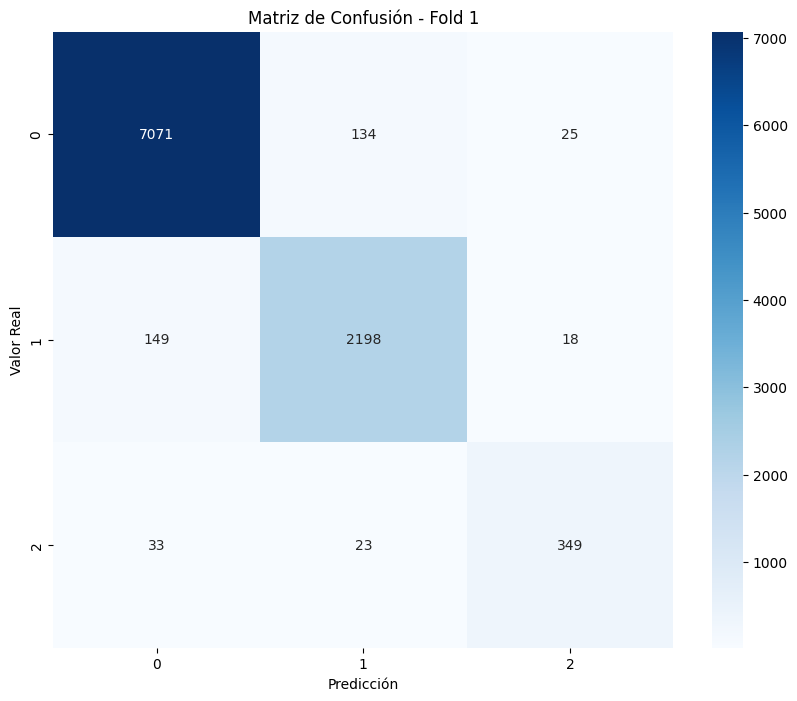

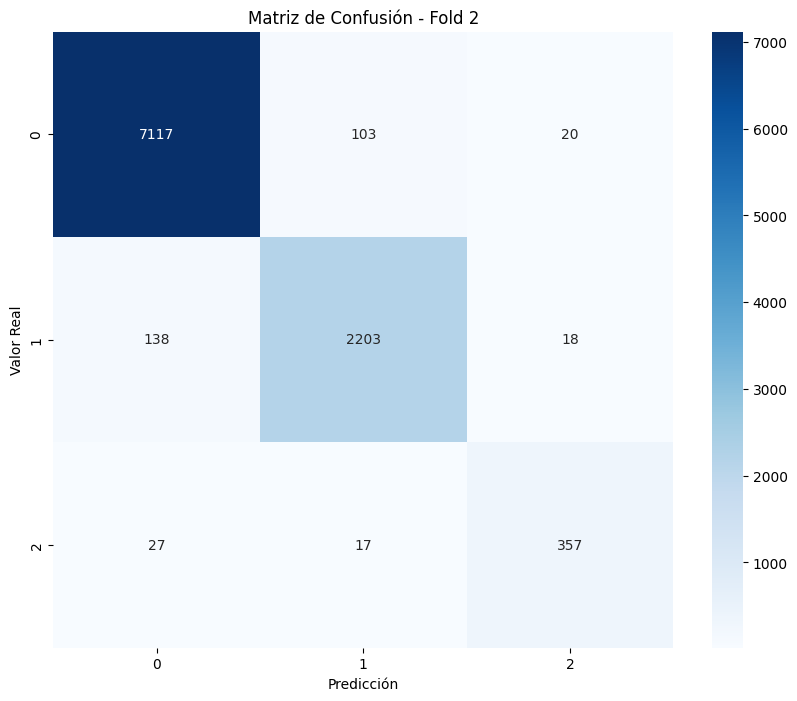

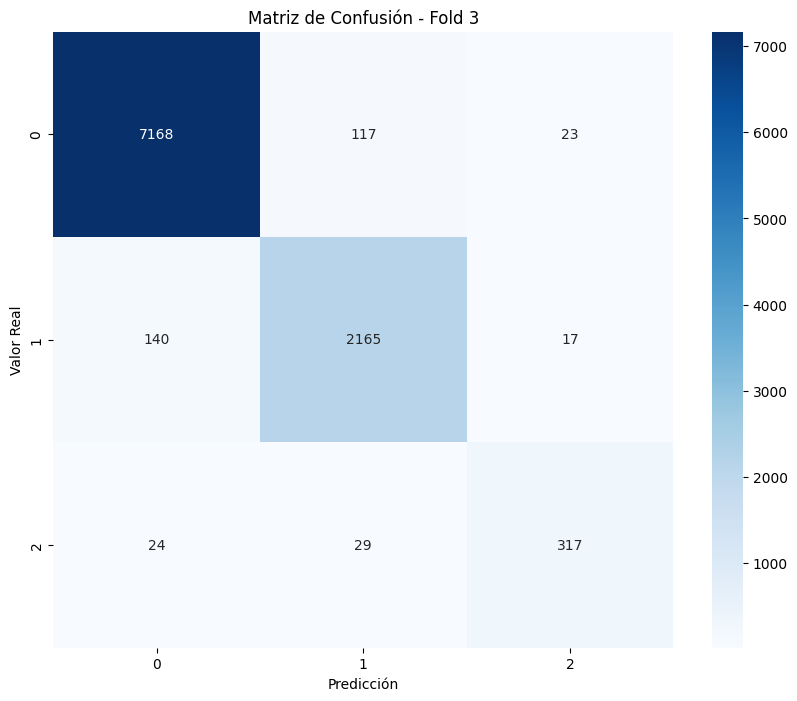

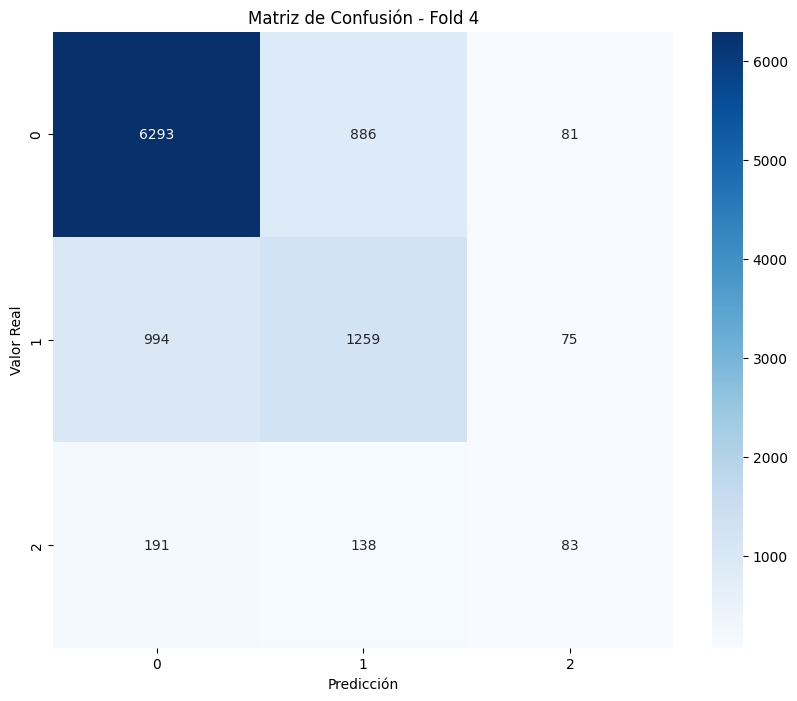

'print("Mejor puntaje (validación):")\nprint(search.best_score_)\n{\'subsample\': 1.0, \'num_leaves\': 63, \'n_estimators\': 500, \'min_child_samples\': 10, \'max_depth\': -1, \'learning_rate\': 0.2}\nprint("Mejor puntaje (validación):")\nprint(search.best_params_)'

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    n_jobs=-1,
    num_leaves=63,
    learning_rate=0.2,
    n_estimators=500,
    min_child_samples=10,
    max_depth=-1,
    subsample=1.0
)

lst = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    model.fit(X_train_kf, y_train_kf)
    lst.append(model)
    y_pred_kf = model.predict(X_test_kf)
    
    print(f"Fold results:\n{classification_report(y_test_kf, y_pred_kf)}")

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    y_pred_kf = lst[i].predict(X_test_kf)
    
    cm = confusion_matrix(y_test_kf, y_pred_kf)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - Fold {i+1}')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.show()

"""#{'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2}

model.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_test, y_test)],  # Establece el conjunto de validación
    eval_metric='multi_logloss',  # Métrica para evalu                   # Muestra el progreso
)


y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Imprimir reporte de clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))
#model.fit(X_train, y_train)"""
# 
"""print("Mejor puntaje (validación):")
print(search.best_score_)
{'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2}
print("Mejor puntaje (validación):")
print(search.best_params_)"""


Precisión final después de fusionar predicciones: 0.962875


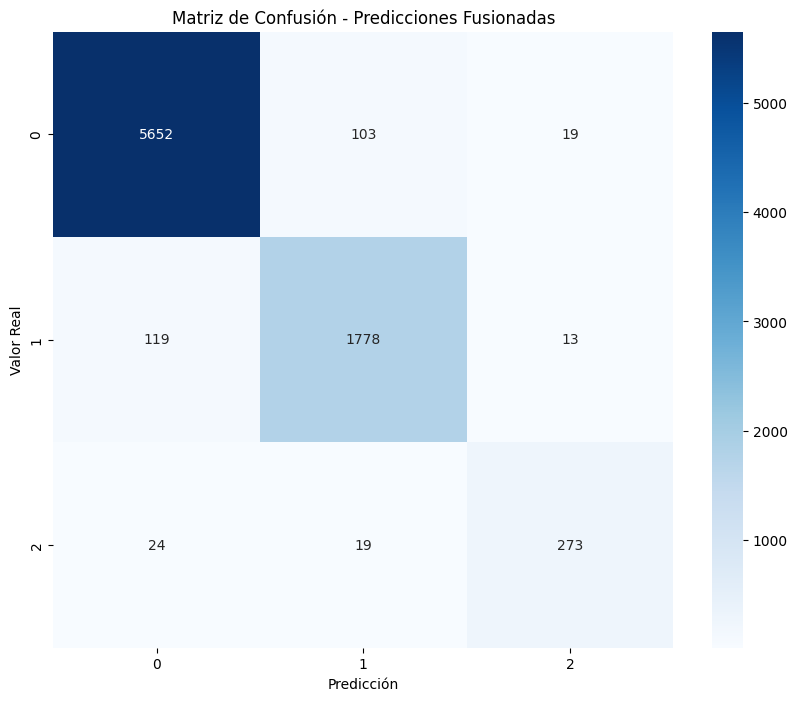

In [80]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

"""# Extraer los parámetros de los modelos en la lista
params_list = [model.get_params() for model in lst[:2]]

# Promediar los parámetros numéricos entre los tres modelos
combined_params = {
    'learning_rate': np.mean([params['learning_rate'] for params in params_list]),
    'min_child_samples': int(np.mean([params['min_child_samples'] for params in params_list])),
    'n_estimators': int(np.mean([params['n_estimators'] for params in params_list])),
    'n_jobs': -1,  # Mantener el valor constante
    'num_class': 3,  # Mantener el valor constante
    'num_leaves': int(np.mean([params['num_leaves'] for params in params_list])),
    'objective': 'multiclass',  # Mantener el valor constante
    'random_state': 42  # Mantener el valor constante
}

# Crear el nuevo modelo combinado con los parámetros promediados
combined_model = LGBMClassifier(**combined_params)

# Entrenar el modelo combinado (si se necesita entrenar desde cero)
combined_model.fit(X_train, y_train)

# Hacer predicciones con el modelo combinado
predictions = combined_model.predict(X_test)

# Imprimir las predicciones
print(predictions)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

import matplotlib.pyplot as plt

# Matriz de confusión para el modelo combinado
cm_combined = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo Combinado')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()"""

predictions = []

for model in lst:
    y_pred = model.predict(X_test)  # Predicción para cada modelo
    predictions.append(y_pred)

# Fusionar las predicciones utilizando votación mayoritaria (para clasificación)
predictions = np.array(predictions).T  # Transponer para tener una fila por muestra
fused_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)

# Evaluación de las predicciones fusionadas
accuracy = accuracy_score(y_test, fused_predictions)
print(f'Precisión final después de fusionar predicciones: {accuracy}')

# Matriz de confusión para las predicciones fusionadas
cm_fused = confusion_matrix(y_test, fused_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fused, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Predicciones Fusionadas')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()


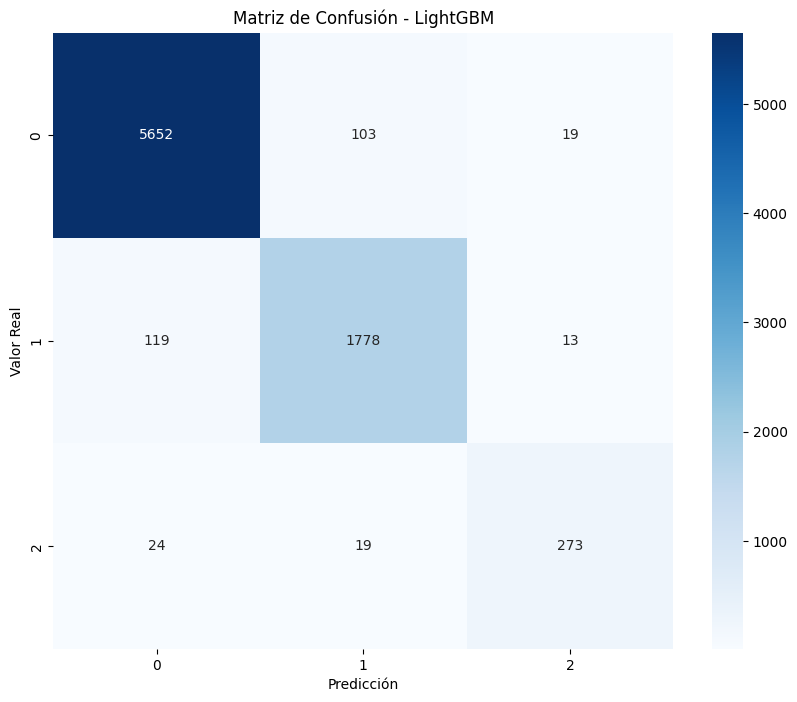

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6691
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 35
[LightGBM] [Info] Start training from score -0.318921
[LightGBM] [Info] Start training from score -1.454002
[LightGBM] [Info] Start training from score -3.233144
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6680
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 35
[LightGBM] [Info] Start training from score -0.319379
[LightGBM] [Info] Start training from score -1

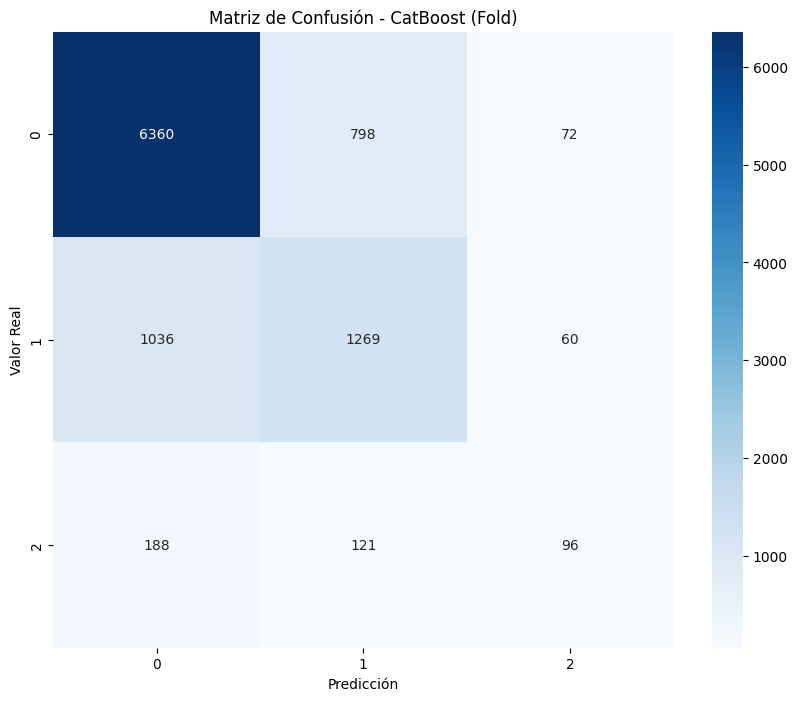

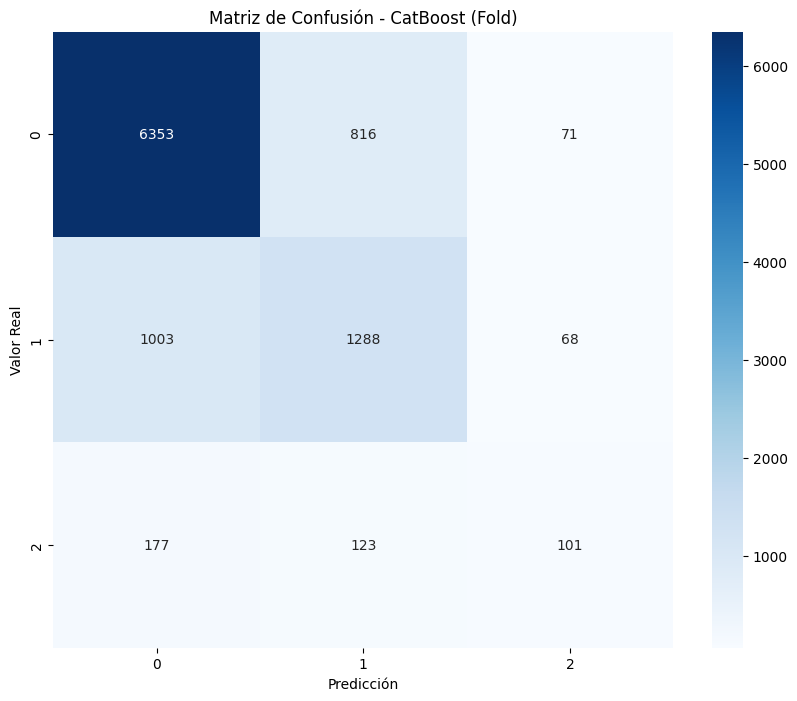

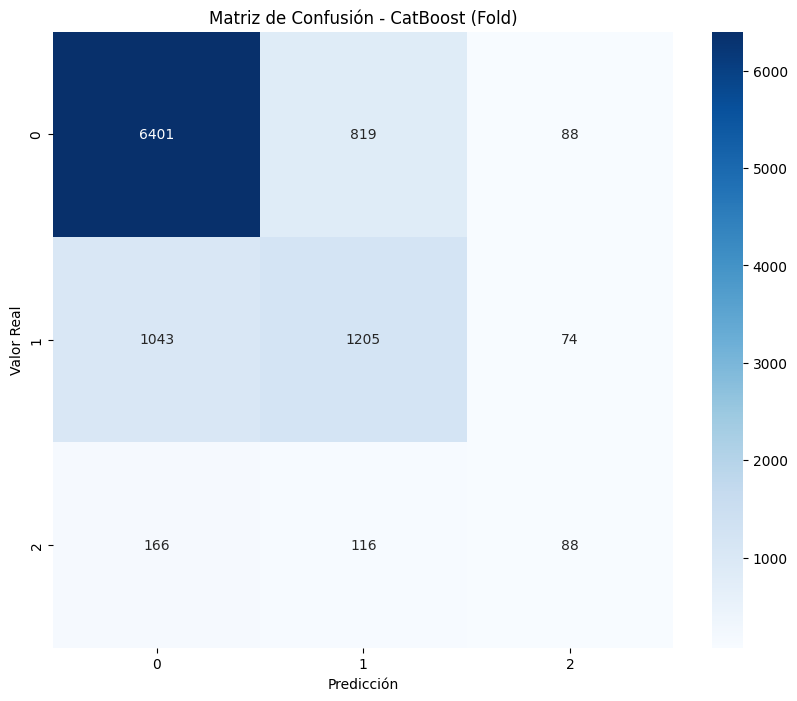

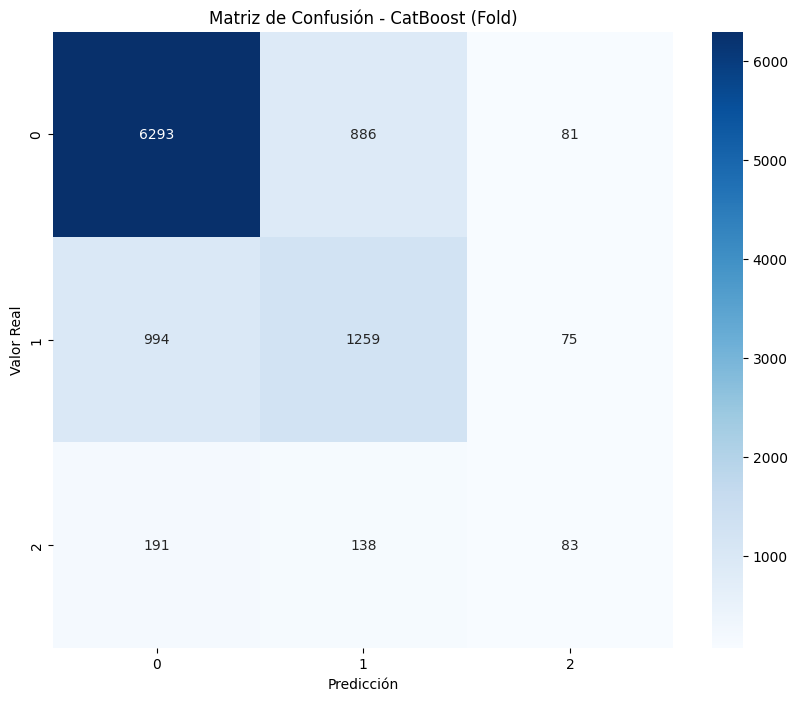

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt

# Matriz de confusión para el modelo LightGBM
y_pred = model.predict(X_test)  # Ensure y_pred is defined
cm_lgb = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - LightGBM')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# Matrices de confusión para cada fold del modelo CatBoost
for train_index, test_index in kf.split(X):
  X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
  y_train_kf, y_test_kf = y[train_index], y[test_index]
  
  model.fit(X_train_kf, y_train_kf)
  y_pred_kf = model.predict(X_test_kf)
  
  cm_catboost = confusion_matrix(y_test_kf, y_pred_kf)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues')
  plt.title('Matriz de Confusión - CatBoost (Fold)')
  plt.ylabel('Valor Real')
  plt.xlabel('Predicción')
  #plt.show()




Accuracy: 0.962875


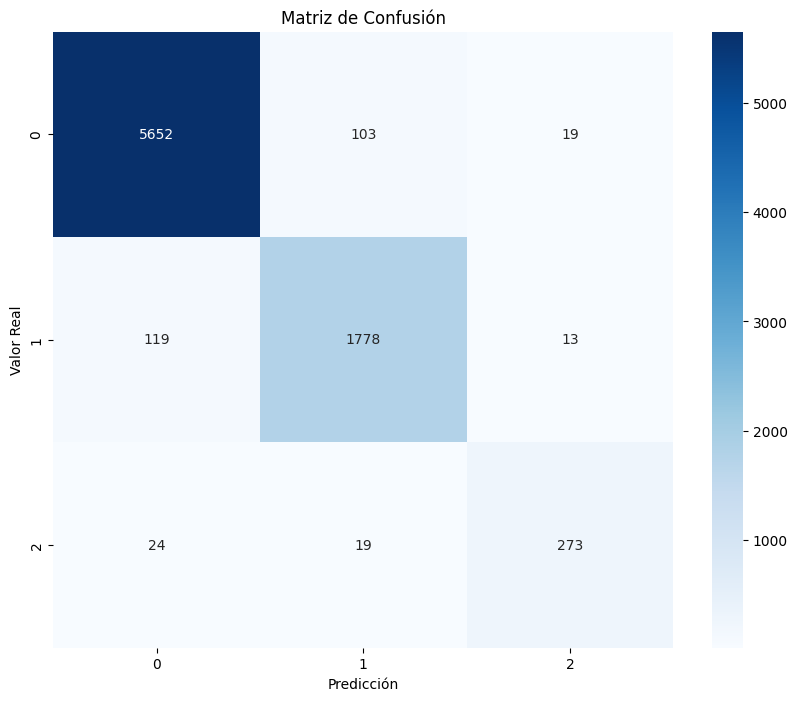

In [74]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

In [81]:
import numpy as np
import joblib
from sklearn.base import BaseEstimator, ClassifierMixin

class VotingEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y):
        # Los modelos ya están fiteados, así que no hacemos nada aquí
        return self
    
    def predict(self, X):
        # Obtener predicciones de todos los modelos
        predictions = [model.predict(X) for model in self.models]
        
        # Fusionar las predicciones usando votación mayoritaria (para clasificación)
        predictions = np.array(predictions).T  # Transponer para tener una fila por muestra
        fused_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)
        
        return fused_predictions

ensemble_model = VotingEnsembleClassifier(models=lst)

In [ ]:
import joblib

joblib.dump(ensemble_model, 'model_accio_5M.joblib')

['model_accio.joblib']